## Example notebook to read GA optimization results

In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
import os

sys.path.append('../ga/mpi_scripts/')
from io_utils import collect_results
from gene_utils import update_C_from_genes

In [2]:
case_dir = '../results/OUTPUT/' # ga output directory 
pd.DataFrame(os.listdir(case_dir), columns = ['cases'])

,cases
0,230616_141953


In [3]:
case = '230616_141953' # filename of the case (date_time when ga was run)

result = collect_results(case, 
                         case_dir, 
                         dump_keys=['best', 'dump'])

config = result['config'] # load config

config

{'n_organisms': 128,
 'n_elites': 8,
 'n_generations': 10,
 'crossover_rate': 1.0,
 'mutation_rate': 1.0,
 'gamma': 0.05,
 'output_folder_name': '../../results/OUTPUT',
 'loss': 'RMSE',
 'filename_so': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/libina.so',
 'filename_legend_states': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/legend_states.csv',
 'filename_legend_algebraic': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/legend_algebraic.csv',
 'filename_legend_constants': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/legend_constants.csv',
 'columns_model': 'I_out',
 'experimental_conditions': {'common': {'params': {'a0_m': {'bounds': [0.1,
      2.0],
     'is_multiplier': True},
    'b0_m': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    'delta_m': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    's_m': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    'tau_m_const': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    

### The loss function decrease during optimization

Text(0.5, 0, 'generations')

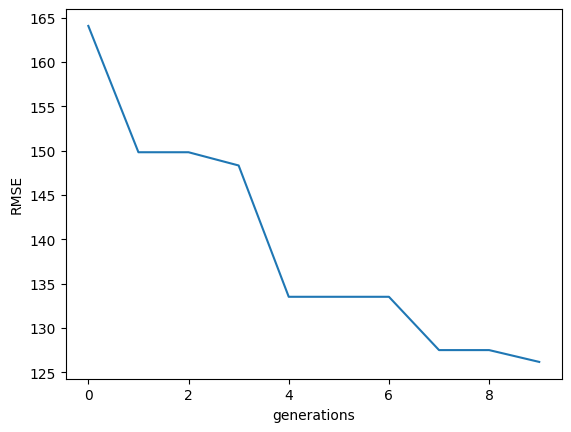

In [4]:
loss = result['dump']['best']['loss'] # loss during generations

plt.plot(loss)
plt.ylabel(config['loss'])
plt.xlabel('generation')

### Load the best fit solution vector of model parameters

In [5]:
experiment_conditions_list = list(config['experimental_conditions'].keys())
experiment_conditions_list

['common', 'individual']

"experimental_condition" dictionary is defined in 004_Create_json_file.ipynb. Simultanious multiple trace optimization is supported. In this case set of experimental setup model parameters are described in "individual#" nested dictionaries. To load soluton vector of particular trace pass the name of the  "individual#" dictionary as the third argument of "update_C_from_genes" function. In the example below the name of the dictionary is "individual" since single trace optimization was used.

In [6]:
experiment_condition = 'individual' 

sol_best = result['sol_best'] # best solution vector
legend_constants = config['runtime']['legend']['constants']
C = deepcopy(legend_constants)
update_C_from_genes(C, sol_best, experiment_condition, config)

### Show all states from ga result

In [7]:
phenotype_best = result['phenotype_best'] # best phenotype is stored as DataFrame with states on every time step 
protocol = config['experimental_conditions'][experiment_condition]['protocol']  #protocol


shape = np.shape(protocol.drop('t', axis=1))
dt = protocol['t'][1]
t = np.arange(0, shape[0]*shape[1]*dt, dt)

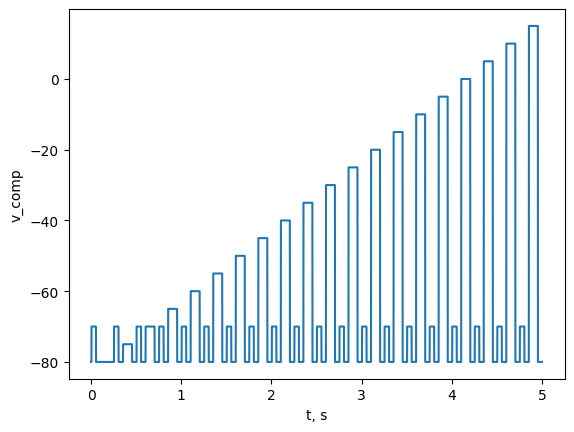

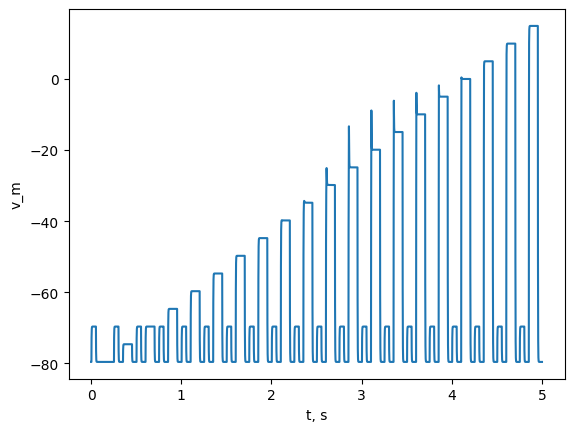

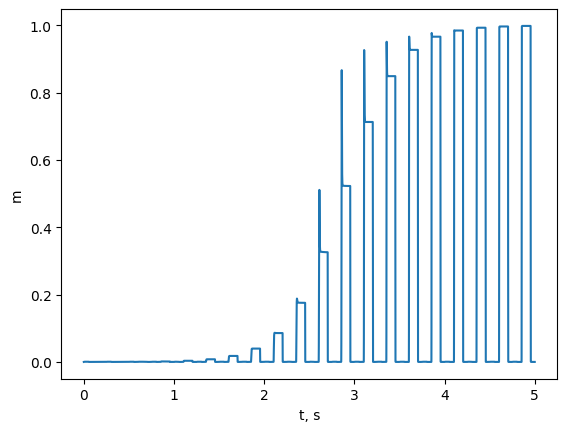

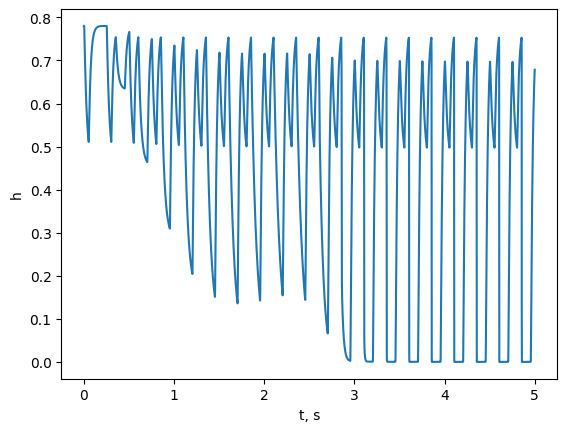

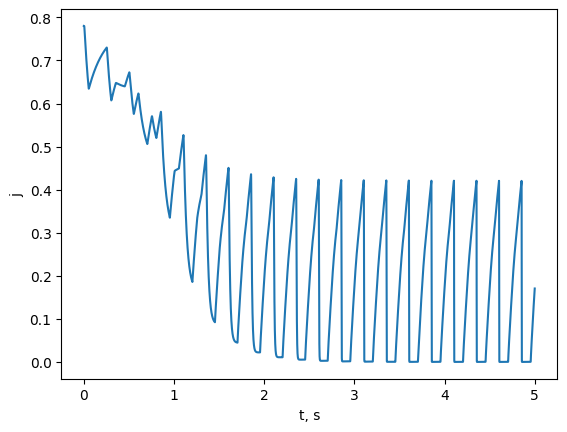

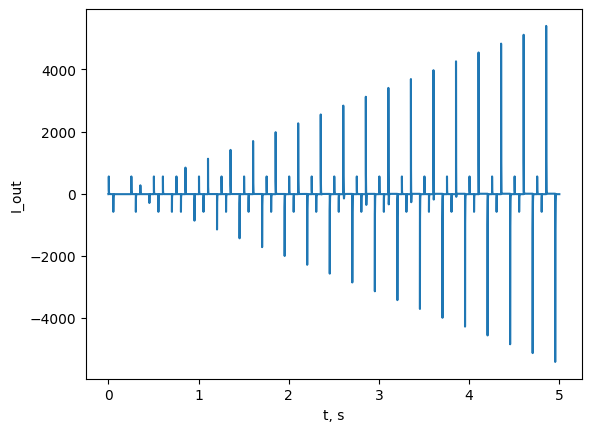

In [8]:
for state in phenotype_best[experiment_condition]:
    plt.figure()
    plt.plot(t, phenotype_best[experiment_condition][state])
    plt.xlabel('t, s')
    plt.ylabel(state)
    

### Compare experimental phenotype with GA result

Text(0, 0.5, 'I_out')

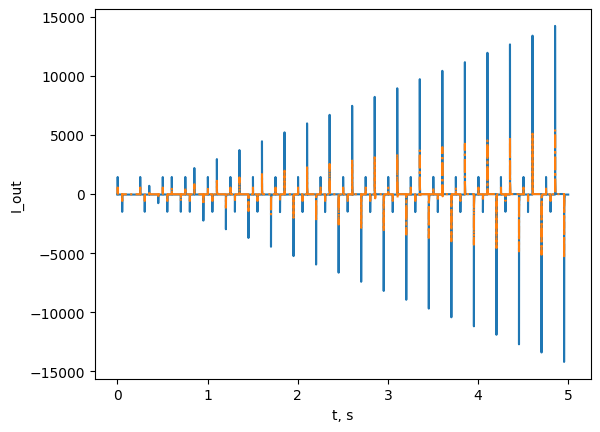

In [9]:
experimental_phenotype = config['experimental_conditions'][experiment_condition]['phenotype'] # experimentral data

plt.plot(t, experimental_phenotype)
plt.plot(t, phenotype_best[experiment_condition]['I_out'], '-.')
plt.xlabel('t, s')
plt.ylabel(state)

### Show the sodium current voltage dependent characteristics
The model of sodium current, which was used in ga, was additionally written in '../src/python_func/models'.  If you use another current model, write the function, in which the input would be voltage and vector of constants and output would be the current characteristics, if it is necessary 

In [10]:
sys.path.append('../src/python_func/')
from models import model1

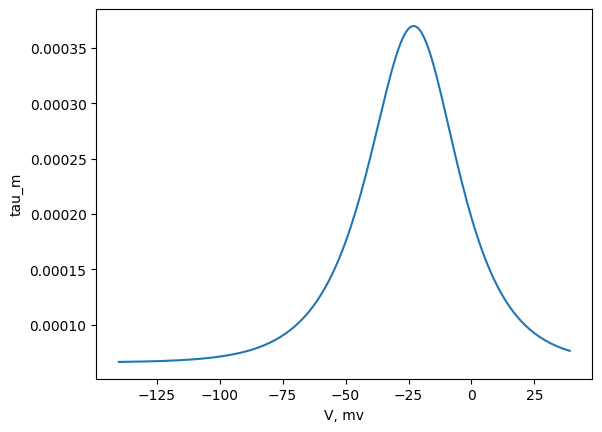

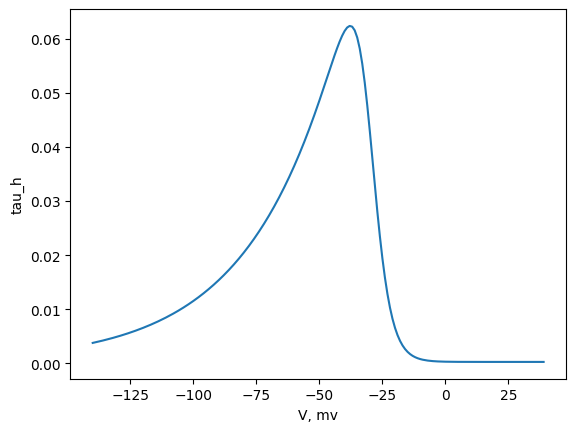

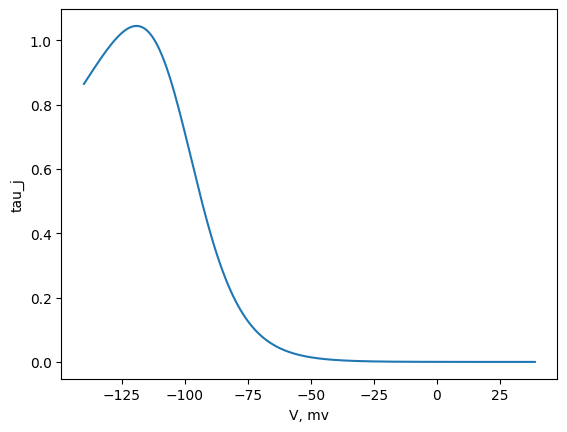

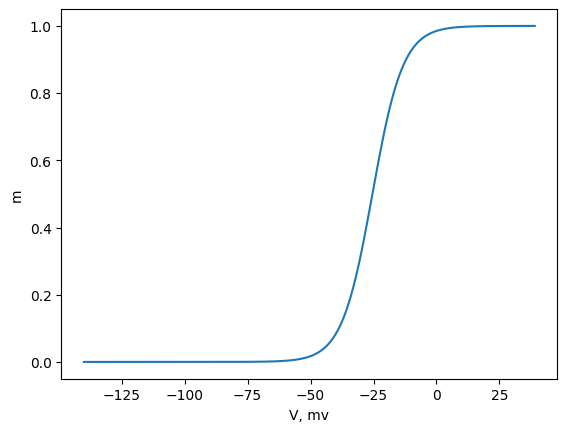

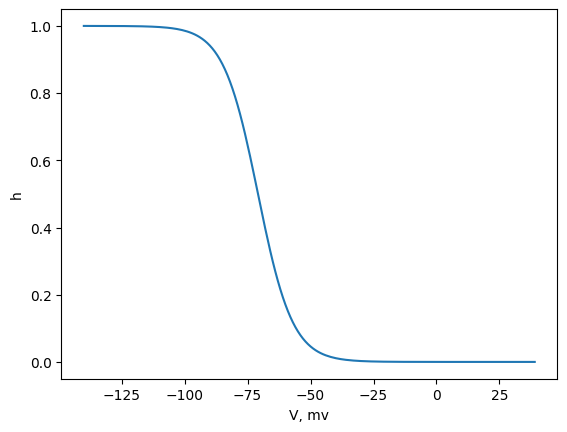

In [11]:
v = np.arange(-140, 40)
current_parameters = model1(v, C)
for param_name in current_parameters:
    plt.figure()
    plt.plot(v, current_parameters[param_name])
    plt.xlabel('V, mv')
    plt.ylabel(param_name)